In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [10]:
import numpy as np
import scipy as sc
import pickle
import sys
import os
import matplotlib.pyplot as plt
from skimage import io
import skimage

In [ ]:
#mount is only as fast as internet connection

In [41]:
root = "/home/chase/mnt/uwdrive/Phytolith Images for Machine Learning /"
subfamily = "Bambusoideae- Subfamily"
tribe = "Arundinarieae - Tribe"
stack_files = "Image stack files - Arundinarieae"
tif = "Shibataea_PMR_2152.lif - Series011 - C=1.tif"

samplepath = "/".join([root, subfamily, tribe, stack_files, tif])

(217, 512, 512)


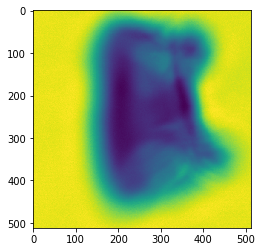

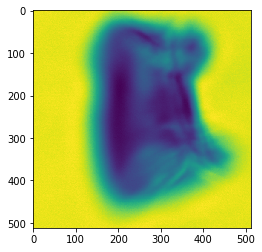

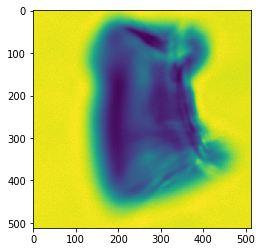

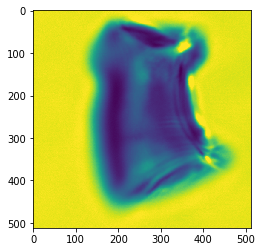

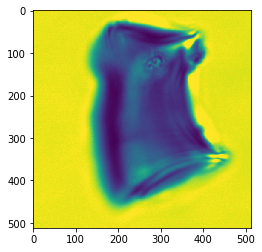

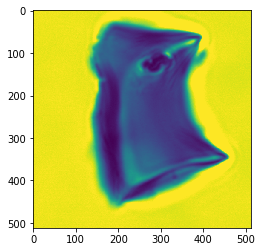

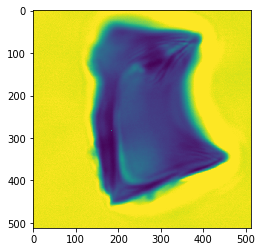

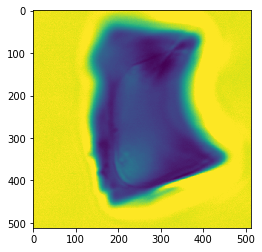

In [42]:
im = io.imread(samplepath)
print(im.shape)

for i in range(int(im.shape[0]/25)):
   plt.imshow(im[25*i,:,:])
   #plt.title(‘Layer %s’ % i)
   plt.show()

In [11]:
#read across paths
root = "/home/chase/projects/pyphy/data/phytolith_image_family"
subfamilies = os.listdir(root)
snames = set()
data = {}
for sf in subfamilies: #Oryzoideae and Bambusoideae
    tribes = os.listdir(root + "/" + sf)
    for t in tribes:
        print(t)
        stack_file_folders = os.listdir(root + "/" + sf + "/" + t)
        for sff in stack_file_folders:
            print(sff)
            samples = os.listdir(root + "/" + sf + "/" + t + "/" + sff)
            for sample in samples:
                print(sample)
                #need to do case by case parsing of file names
                tokens = sample.split(" ")
                if tokens[0] == "Copy":
                    sname = tokens[2].split("_")[0]
                else:
                    sname = tokens[0].split("_")[0]
                if len(sname.split("-")) > 1:
                    sname = sname.split("-")[0]
                if len(sname.split(".")) > 1:
                    sname = sname.split(".")[0]
                if len(sname.split("2")) > 1:
                    sname = sname.split("2")[0]
                snames.add(sname)
                if sname not in data.keys():
                    im = io.imread(root + "/" + sf + "/" + t + "/" + sff + "/" + sample)
                    data[sname] = [im]
                else:
                    data[sname].append(im)
        

Oryzeae
Image Stacks - Oryzeae
Oryza_barthii_NEW.lif - Series015 - C=1.tif
Olyreae - Tribe
Image Stacks - Olyreae
Lithacne_pauciflora3.lif - Series034 - C=1.tif
Diandrolyra_3_Series010_Brightfield (2).tif
Copy of sucrea2_Series036_brightfield.tif
Copy of Raddia_7-13_Series017_brightfield.tif
Lithacne_pauciflora2.lif - Series004 - C=1.tif
Lithacne_7-12.lif - Series002 - C=1.tif
Pariana_sp.lif - Series009 - C=1.tif
Diandrolyra2.lif - Series024 - C=1.tif
Copy of Raddia-7-13_Series005_Brightfield.tif
Arundinarieae - Tribe
Image stack files - Arundinarieae
Shibataea_PMR_2152.lif - Series011 - C=1.tif


In [12]:
#example data

import pickle

with open("/home/chase/projects/pyphy/data/phytolith_data_parse.pck", 'wb') as d:
    pickle.dump(data, d)
    #data = pickle.load(d)
    


In [ ]:
with open("/home/chase/projects/pyphy/data/phytolith_data_parse.pck", 'rb') as d:
    #pickle.dump(data, d)
    data = pickle.load(d)

In [5]:
for s in data.keys():
    for smpl in data[s]:
        print(smpl.shape)

AttributeError: module 'skimage.data' has no attribute 'keys'

In [21]:
list(data)

['Pariana',
 'sucrea',
 'Shibataea',
 'Lithacne',
 'Oryza',
 'Diandrolyra',
 'Raddia']

(100, 100)


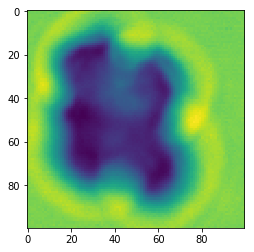

(100, 100)

In [31]:
image = data[list(data)[0]][0]
image = skimage.transform.resize(image[0], (100, 100), mode='reflect') #anti_aliasing argument not recognized
                                                                       #looking at a single layer

print(image.shape)
plt.imshow(image)
plt.show()
image.shape

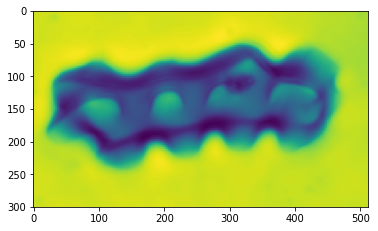

In [41]:
image = data[list(data)[5]][0]
image.shape
im_mean = np.mean(image, axis=0)

plt.imshow(im_mean)
plt.show()

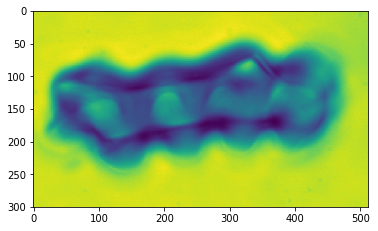

In [42]:
np.random.choice(image.shape[0], 10)
im_sub = image[np.random.choice(image.shape[0], 10), :, :]
im_mean = np.mean(im_sub, axis=0)

plt.imshow(im_mean)
plt.show()

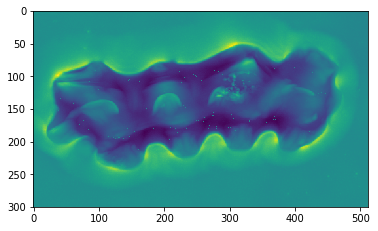

In [44]:
image = data[list(data)[5]][0]
image.shape
im_max = np.max(image, axis=0)

plt.imshow(im_max)
plt.show()

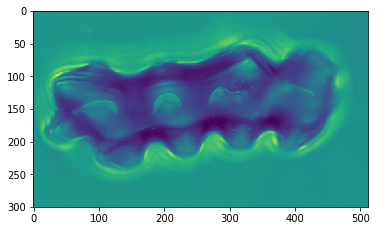

In [45]:
np.random.choice(image.shape[0], 10)
im_sub = image[np.random.choice(image.shape[0], 10), :, :]
im_max = np.max(im_sub, axis=0)

plt.imshow(im_max)
plt.show()

In [53]:
def get_num_total_stacks(data_dict):
    j = 0
    for s in data_dict:
        j += len(data_dict[s])
    return(j)

In [105]:
#lets seperate out into train examples and validate examples
#90% train 10% validate
train_prop = 0.9
batch = 10 #number of images to generate from training stack
batch_val = 2 #number of images to generate from validation stack
resize_dim = 64 #reshape all images to square 32 X 32, rollout data to 1024 vectors
num_stacks = get_num_total_stacks(data)

X_train = np.zeros((batch * num_stacks, np.power(resize_dim, 2)))
Y_train = np.zeros((batch * num_stacks, 1))
X_val = np.zeros((batch_val * num_stacks, np.power(resize_dim, 2)))
Y_val = np.zeros((batch_val * num_stacks, 1))

labels = np.arange(0,len(data), 1)
itr_x_train = 0
itr_x_val = 0
itr_y = 0
for s in data: #python3 doesn't need you to explicitly call keys()
    for ex in data[s]:
        layers = ex.shape[0]
        train_i = np.random.choice(layers, int(train_prop * float(layers)))
        val_i = [ i for i in range(layers) if i not in train_i ]
        train_stack = ex[train_i, :, :] #careful for RGB channels when considering all data
        val_stack = ex[val_i, :, :]
        
        train_stack_size = int(float(len(train_i))/float(batch))
        val_stack_size = int(float(len(val_i))/float(batch_val))
        
        #training data
        for j in range(batch):
            curr_im = train_stack[j*train_stack_size:(j+1)*train_stack_size,:,:]
            #im = np.mean(curr_im, axis=0)
            im = np.max(curr_im, axis=0)
            im = skimage.transform.resize(im, (resize_dim, resize_dim), mode='reflect')
            im_out = np.reshape(im, (1,np.power(resize_dim, 2)))
            X_train[itr_x_train,:] = im_out
            Y_train[itr_x_train,:] = labels[itr_y]
            itr_x_train += 1
        
        #validation data
        for k in range(batch_val):
            curr_im = val_stack[k*val_stack_size:(k+1)*val_stack_size,:,:]
            #im = np.mean(curr_im, axis=0)
            im = np.max(curr_im, axis=0)
            im = skimage.transform.resize(im, (resize_dim, resize_dim), mode='reflect')
            im_out = np.reshape(im, (1,np.power(resize_dim, 2)))
            X_val[itr_x_val,:] = im_out
            Y_val[itr_x_val,:] = labels[itr_y]
            itr_x_val += 1
    
    itr_y += 1

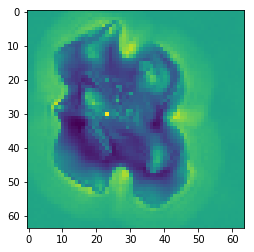

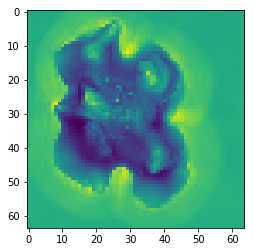

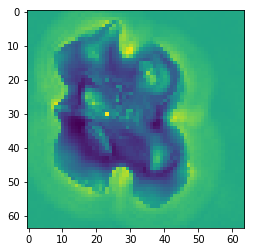

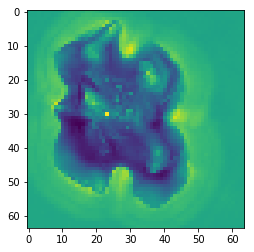

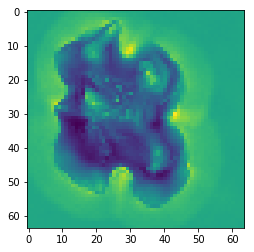

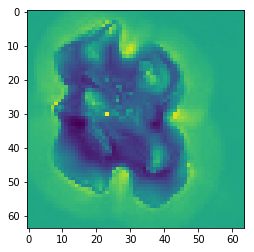

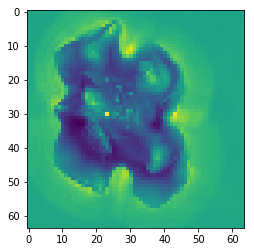

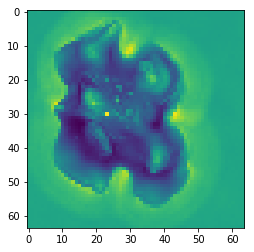

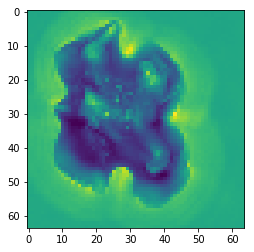

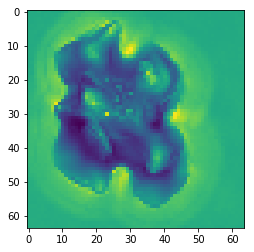

In [108]:
for i in range(10):
    plt.imshow(np.reshape(X_train[i,:],(64,64)))
    plt.show()

In [109]:
def train(X, Y, lamb):
    A = X.T.dot(X)
    A = A + lamb*np.identity(A.shape[0])
    b = X.T.dot(Y)
    W_hat = np.linalg.solve(A, b)
    return(W_hat)

def predict(W, X):
    ret = W.T.dot(X.T)
    return(list(np.argmax(ret, axis=0)))

def accuracy(y_true, y_hat):
    ones = []
    for i in range(len(y_true)):
        if int(y_true[i]) == int(y_hat[i]):
            ones.append(1.0)
        else:
            ones.append(0.0)
    return(np.mean(np.array(ones)))

In [110]:
#basic regularized linear regression
W_hat = train(X_train, Y_train, 0.1)


In [111]:
Y_hat = predict(W_hat, X_train)
accuracy(Y_train, Y_hat)

0.090909090909090912

In [112]:
Y_hat_test = predict(W_hat, X_val)
accuracy(Y_val, Y_hat_test)

0.090909090909090912

In [113]:
def random_transform_params(mu, var, p):
    G = np.sqrt(var) * np.random.randn(p, 1024) + mu #d = 28 x 28 flattened
    b = np.random.uniform(0,2*np.pi,size=p)
    return(G, b)

def cos_transform(G, b, X):
    H = np.cos(G.dot(X.T) + np.stack([ b for i in range(X.T.shape[1]) ], axis=1))
    return(H)

In [118]:
#SVM 
from sklearn import svm
from sklearn.model_selection import train_test_split

"""
#adding noisy features
random_state = np.random.RandomState(0)
n_samples, n_features = X_train.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]
"""

# Create a simple classifier
#classifier = svm.LinearSVC(random_state=random_state)
classifier = svm.LinearSVC()
classifier.fit(X_train, Y_train)
y_score = classifier.decision_function(X_val)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [119]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(Y_val, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

ValueError: multiclass format is not supported

In [120]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(Y_val, y_score)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

ValueError: multiclass format is not supported

In [114]:
#Gradient boosting
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, Y_train)
mse = mean_squared_error(Y_val, clf.predict(X_val))
print("MSE: %.4f" % mse)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE: 3.8317


In [ ]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(Y_val, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))



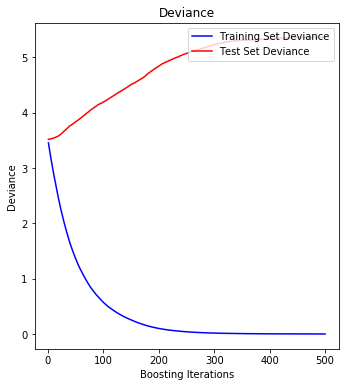

In [115]:
# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_val)):
    test_score[i] = clf.loss_(Y_val, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

plt.show()

In [104]:
y_pred

array([ 3.90829811,  0.29282195,  0.99362086,  3.37126525,  1.90885687,
        1.17027644,  3.21623942,  3.03747495,  4.31521954,  5.11020119,
        4.42209985,  5.2181505 ,  3.99580674,  3.99580674,  4.0600741 ,
        5.03555924,  4.26849528,  0.17041609,  4.10452847,  3.94716462,
        3.19722778,  0.15307024])

In [92]:
print(__doc__)

# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

# #############################################################################
# Load data
boston = datasets.load_boston()
X, y = shuffle(boston.data, boston.target, random_state=13)
X = X.astype(np.float32)


Automatically created module for IPython interactive environment


MSE: 6.4471


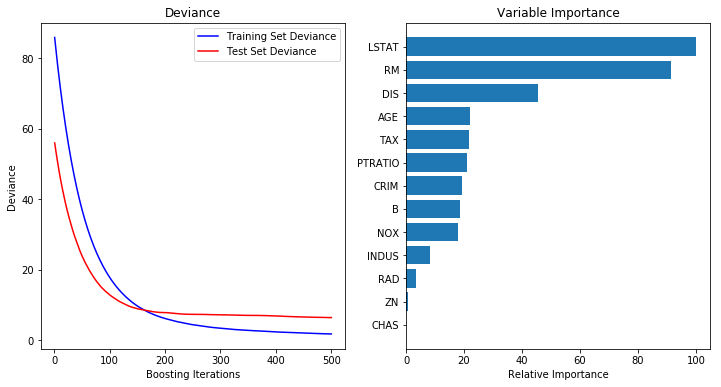

In [95]:
offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:] #this is genius

# #############################################################################
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

# #############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# #############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [94]:
X.shape

(506, 13)